## GLMAT: 2D kernel, ML estimation

In [2]:
from __future__ import print_function, division
import os
import sys
import numpy as np

import mat_neuron._model as mat
from dstrf import strf, mle

# plotting packages
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

/home/dmeliza/.virtualenvs/dstrf/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
# model parameters: (ω, α1, α2, τ1, τ2, tref)
matparams = np.asarray([7, 100, 2, 10, 200, 2], dtype='d')
model_dt = 0.5

# data parameters
duration = 400000
n_samples = int(duration / model_dt)
n_assim = 1
n_test = 0

['bbm', 'wb2', 'nbtf', 'nbs', 'bbf', 'nbts', 'off', 'bbs']


/home/dmeliza/.virtualenvs/dstrf/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


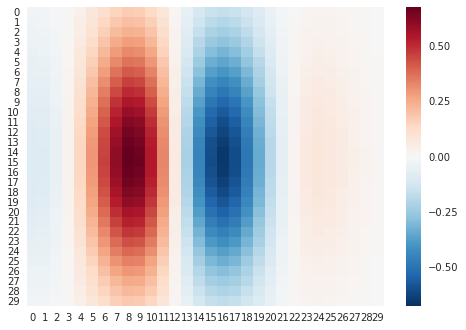

In [5]:
# STRF: keep this very simple for proof of principle
stim_dt = 10.0
nfreq = 30
ntau  = 30

from scipy.signal import resample
filts = np.load('../../filters.npz')
print(filts.keys())
k1 = resample(filts['bbs'], nfreq, axis=0)[:,:ntau] * 5

plt.imshow(k1, cmap='jet', aspect='auto')

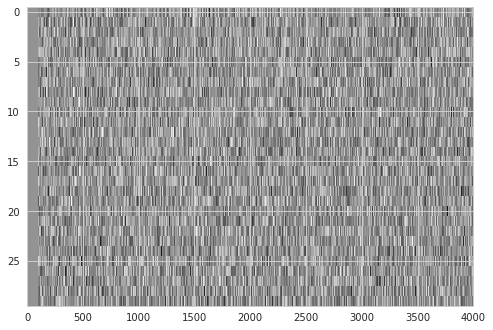

In [6]:
# generate some random data to fit
np.random.seed(1)
stim_dt = 10.0
upsample = int(stim_dt / model_dt)
stim = np.random.randn(nfreq, int(n_samples / (stim_dt / model_dt)))
stim[:,:100] = 0
plt.imshow(stim, aspect='auto')

In [7]:
def filter_stimulus(S, kernel):
    """Convolve spectrogram S with spectrotemporal kernel. Kernel should not be flipped."""
    nf, nt = S.shape
    X = np.zeros(nt)
    for i in range(nf):
        X += np.convolve(S[i], kernel[i], mode="full")[:nt]
    return X

def predict_spikes(V, params, dt, upsample):
    omega, a1, a2, t1, t2, tref = params
    return mat.predict_poisson(V - omega, (a1, a2), (t1, t2), tref, 
                               dt, upsample)

In [8]:
data = []
V = filter_stimulus(stim, k1)
for i in range(n_assim + n_test):
    spikes = predict_spikes(V, matparams, model_dt, upsample)
    H = mat.adaptation(spikes, matparams[3:5], model_dt)
    z = np.nonzero(spikes)[0]
    d = {"H": H,
         "duration": duration,
         "spike_t": z, 
         "spike_v": spikes,
        }
    data.append(d)

# split into assimilation and test sets
assim_data = data[:n_assim]
test_data = data[n_assim:]

-2375.16676531


262

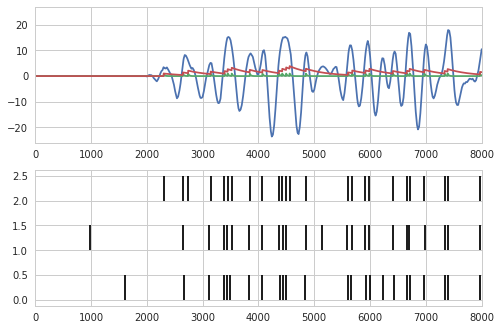

In [9]:
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.plot(V)
for i, d in enumerate(data):
    ax2.vlines(d["spike_t"], i, i + 0.5)
ax1.set_xlim(0, 8000 // upsample)
ax2.set_xlim(0, 8000)
len(data[0]["spike_t"])

## Estimate parameters

In [ ]:
# initial guess of parameters using ML
spikes = np.stack([d["spike_v"] for d in data], axis=1)
mlest = mle.estimator(stim, spikes, ntau, matparams[3:5], stim_dt, model_dt)
w0 = mlest.estimate()

In [ ]:
print(w0[:3])
rf_est = strf.as_matrix(w0[3:], ntau)
plt.subplot(121).imshow(k1, cmap='jet', aspect='auto')
plt.subplot(122).imshow(np.fliplr(rf_est), cmap='jet', aspect='auto')

In [12]:
# estimate parameters using emcee
from neurofit import priors, costs, utils, startpos
import emcee

# assimilation parameters
nthreads = 4
nwalkers = 2000
nsteps = 500

mat_prior = priors.joint_independent(
                [ priors.uniform( 0,  20),
                  priors.uniform(-50,  200),
                  priors.uniform(-5,   10),
                ])

# lasso prior on RF parameters
rf_lambda = 1.0

def lnpost_dyn(theta):
    """Posterior probability for dynamical parameters"""
    mparams = theta[:3]
    rfparams = theta[3:]
    rf_prior = -np.sum(np.abs(rfparams)) * rf_lambda
    ll = mat_prior(mparams) + rf_prior
    if not np.isfinite(ll):
        return -np.inf
    lp = mlest.loglike(theta.astype(mlest.dtype))
    return ll + lp  

In [13]:
# theoretically this is as good as it can get
theta_true = np.concatenate([matparams[:3], strf.as_vector(np.fliplr(k1))])
print("lnpost of p_true: {}".format(lnpost_dyn(theta_true)))
# and this is our initial population of walkers
p0 = startpos.normal_independent(nwalkers, w0, np.abs(w0) * 0.2)
theta_0 = np.median(p0, 0)
print("lnpost of p0 median: {}".format(lnpost_dyn(theta_0)))
%timeit lnpost_dyn(theta_true)

lnpost of p_true: -2656.87835521
lnpost of p0 median: -4830.66865012
100 loops, best of 3: 13.8 ms per loop
CPU times: user 27.6 s, sys: 0 ns, total: 27.6 s
Wall time: 27.7 s


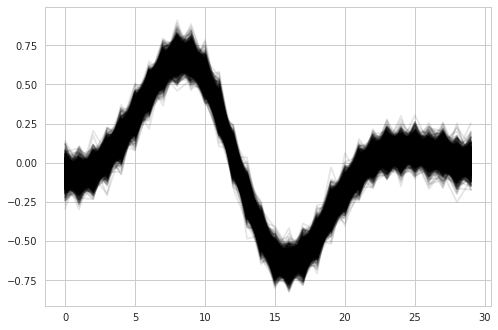

In [23]:
rfall = pos[:,matparams_n:].reshape(2000, nfreq, ntau)
z = rfall[:,15,:].T
plt.plot(z, color='k', alpha=0.1);

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, theta_true.size, lnpost_dyn, threads=nthreads)
tracker = utils.convergence_tracker(nsteps, 25)

for pos, prob, _ in tracker(sampler.sample(p0, iterations=nsteps, storechain=False)): 
    continue

  step      lnprob        time         ETA
------------------------------------------
    25     -4635.8     0:02:17     1:33:08
    50     -4130.2     0:05:42     1:50:56
    75     -4003.1     0:09:33     1:59:41
   100       -3929     0:13:22     2:01:45
   125       -3885     0:17:13     2:01:37
   150     -3841.8     0:21:04     2:00:20
   175     -3810.8     0:24:55     1:58:19
   200     -3781.6     0:28:56     1:56:30
   225       -3763     0:32:55     1:54:04
   250     -3750.8     0:36:49     1:51:03
   275     -3730.9     0:40:47     1:48:04
   300       -3717     0:44:44     1:44:53
   325     -3703.3     0:48:54     1:42:03
   350     -3685.5     0:52:55     1:38:43
   375     -3679.8     0:56:55     1:35:17
   400     -3669.7     1:00:55     1:31:46
   425     -3660.6     1:05:00     1:28:18
   450     -3650.9     1:09:09     1:24:52
   475     -3641.3     1:13:12     1:21:14
   500     -3632.3     1:17:12     1:17:30
   525     -3624.7     1:21:12     1:13:46
   550     